In [3]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def leer_acelerograma_csv(filepath, magnitud_min=4.8):
    """
    Lee un archivo CSV con datos sísmicos del IGP
    Filtra por magnitud mínima
    """
    try:
        df = pd.read_csv(filepath, encoding='utf-8-sig')
        
        # Verificar que tenga las columnas necesarias
        columnas_requeridas = ['acel_z', 'acel_n', 'acel_e']
        if not all(col in df.columns for col in columnas_requeridas):
            print(f"⚠️ Advertencia: {os.path.basename(filepath)} no tiene todas las columnas requeridas")
            return None
        
        # Convertir columnas de aceleración a numérico
        df['Z'] = pd.to_numeric(df['acel_z'], errors='coerce')
        df['N'] = pd.to_numeric(df['acel_n'], errors='coerce')
        df['E'] = pd.to_numeric(df['acel_e'], errors='coerce')
        
        # Obtener magnitud (tomar el primer valor ya que es igual para todo el archivo)
        if 'magnitud' in df.columns:
            magnitud_str = df['magnitud'].iloc[0]
            # Extraer el número de magnitud (puede venir como "M5.5" o "5.5")
            if isinstance(magnitud_str, str):
                magnitud = float(magnitud_str.replace('M', '').strip())
            else:
                magnitud = float(magnitud_str)
        else:
            magnitud = 0
        
        # Filtrar por magnitud
        if magnitud <= magnitud_min:
            return None
        
        # Crear columna de tiempo si no existe
        if 'tiempo_s' not in df.columns:
            if 'muestreo' in df.columns:
                muestreo_str = df['muestreo'].iloc[0]
                # Extraer el número de muestreo (puede venir como "100muestras/segundo")
                muestreo_hz = float(muestreo_str.split('muestras')[0]) if isinstance(muestreo_str, str) else 100.0
            else:
                muestreo_hz = 100.0
            
            df['tiempo_s'] = df.index / muestreo_hz
        
        # Agregar nombre de archivo
        df['archivo'] = os.path.basename(filepath)
        
        return df
        
    except Exception as e:
        print(f"❌ Error leyendo {os.path.basename(filepath)}: {e}")
        return None


In [5]:
def leer_todos_los_csv(ruta_carpeta, magnitud_min=4.8):
    """
    Lee todos los archivos CSV de una carpeta específica
    Filtra por magnitud mínima
    """
    start_time = time.time()
    registros = []
    
    # Buscar archivos CSV en la carpeta
    archivos_csv = [f for f in os.listdir(ruta_carpeta) if f.lower().endswith('.csv')]
    total_archivos = len(archivos_csv)
    
    print(f"\n📂 Iniciando lectura de {total_archivos} archivos CSV en '{ruta_carpeta}'...\n")
    
    leidos = 0
    validos = 0
    
    for archivo in archivos_csv:
        filepath = os.path.join(ruta_carpeta, archivo)
        df = leer_acelerograma_csv(filepath, magnitud_min)
        leidos += 1
        
        if df is not None:
            registros.append(df)
            validos += 1
            # Obtener magnitud para mostrar
            mag = df['magnitud'].iloc[0] if 'magnitud' in df.columns else 'N/A'
            print(f"✅ ({leidos}/{total_archivos}) {archivo} [M = {mag}]")
        else:
            print(f"⏩ ({leidos}/{total_archivos}) {archivo} descartado (M ≤ {magnitud_min} o sin datos)")
    
    elapsed = time.time() - start_time
    print(f"\n📊 Lectura completada en {elapsed:.2f} segundos.")
    print(f"✅ Archivos válidos: {validos} / {total_archivos}")
    
    if registros:
        df_total = pd.concat(registros, ignore_index=True)
        print(f"📈 Total de registros (filas): {len(df_total)}")
        return df_total
    else:
        print("❌ No se encontraron archivos con magnitud superior al umbral.")
        return pd.DataFrame()


In [6]:
def analizar_estacion(df, nombre_estacion):
    """
    Filtra y analiza datos de una estación específica
    """
    df_estacion = df[df['nombre'] == nombre_estacion].copy()
    
    if len(df_estacion) == 0:
        print(f"⚠️ No se encontraron datos para la estación: {nombre_estacion}")
        return None
    
    print(f"\n📍 Estación: {nombre_estacion}")
    print(f"   Registros: {len(df_estacion)}")
    
    return df_estacion

In [7]:
def graficar_acelerogramas(df, titulo="Acelerogramas"):
    """
    Grafica los tres componentes de aceleración
    """
    plt.figure(figsize=(12, 6))
    
    # Calcular PGA
    PGA_E = df['E'].abs().max()
    PGA_N = df['N'].abs().max()
    PGA_Z = df['Z'].abs().max()
    
    plt.plot(df['tiempo_s'], df['E'], color='r', alpha=0.7, linewidth=0.8,
             label=f'Eje E - PGA: {PGA_E:.4f} cm/s²')
    plt.plot(df['tiempo_s'], df['N'], color='b', alpha=0.7, linewidth=0.8,
             label=f'Eje N - PGA: {PGA_N:.4f} cm/s²')
    plt.plot(df['tiempo_s'], df['Z'], color='g', alpha=0.7, linewidth=0.8,
             label=f'Eje Z - PGA: {PGA_Z:.4f} cm/s²')
    
    plt.xlabel('Tiempo (s)', fontsize=14)
    plt.ylabel('Aceleración [cm/s²]', fontsize=14)
    plt.title(titulo, fontsize=16)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {'PGA_E': PGA_E, 'PGA_N': PGA_N, 'PGA_Z': PGA_Z}

🌍 LECTOR DE DATOS SÍSMICOS IGP - CSV

📂 Iniciando lectura de 2 archivos CSV en '2021_csv/IGPACELDAT-PERU 2021-0007'...

✅ (1/2) 2021_0007_MOQA_PE.csv [M = M5]
✅ (2/2) 2021_0007_TOQA_PE.csv [M = M5]

📊 Lectura completada en 0.16 segundos.
✅ Archivos válidos: 2 / 2
📈 Total de registros (filas): 32002

📋 RESUMEN DE DATOS
Total de registros: 32002

Columnas disponibles:
['codigo', 'latitud_estacion', 'longitud_estacion', 'fecha_local', 'hora_local', 'latitud_sismo', 'longitud_sismo', 'profundidad', 'magnitud', 'dist_epicentral', 'tiempo_inicio', 'num_muestras', 'muestreo', 'unidades', 'pga_z', 'pga_n', 'pga_e', 'acel_z', 'acel_n', 'acel_e', 'Z', 'N', 'E', 'tiempo_s', 'archivo']

📊 Graficando todos los registros...


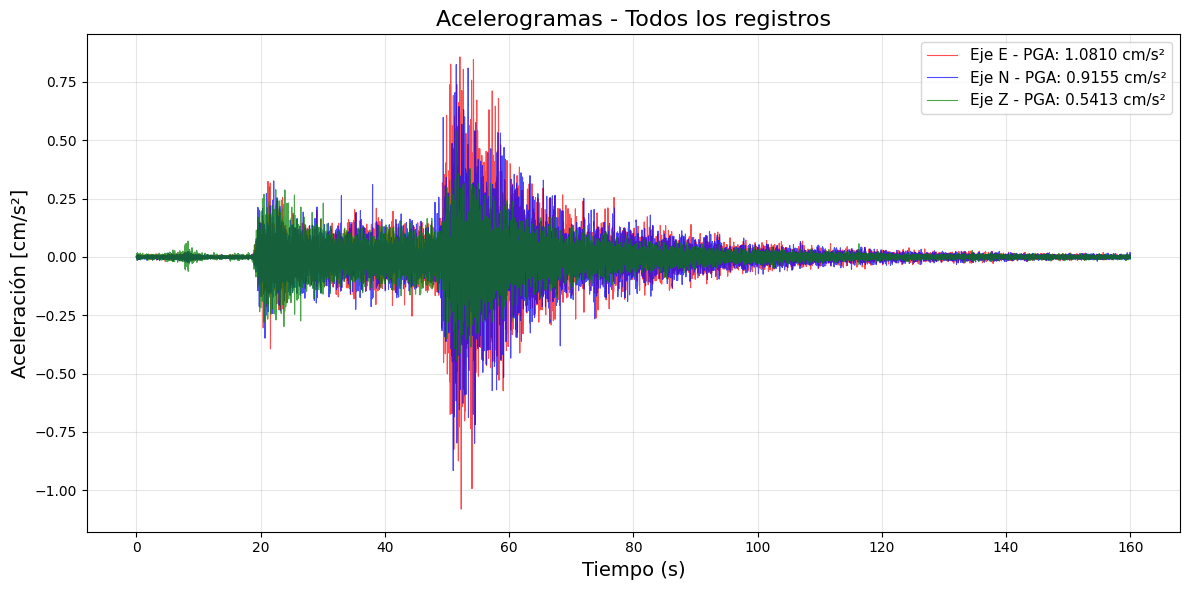


💾 Datos guardados en: registros_sismicos_combinados/registros_sismicos_combinados_IGPACELDAT-PERU 2021-0007.csv

✅ Proceso completado


In [14]:
# ============================================
# EJEMPLO DE USO
# ============================================

if __name__ == "__main__":
    # 1. Leer todos los CSV de una carpeta específica
    ruta_carpeta = "2021_csv/IGPACELDAT-PERU 2021-0007" 
    nombre_carpeta = "IGPACELDAT-PERU 2021-0007"
    print("="*60)
    print("🌍 LECTOR DE DATOS SÍSMICOS IGP - CSV")
    print("="*60)
    
    # 2. Leer archivos con magnitud mínima de 4.8
    df_sismico = leer_todos_los_csv(ruta_carpeta, magnitud_min=4.8)
    
    if not df_sismico.empty:
        # 3. Mostrar resumen
        print("\n" + "="*60)
        print("📋 RESUMEN DE DATOS")
        print("="*60)
        print(f"Total de registros: {len(df_sismico)}")
        print(f"\nColumnas disponibles:")
        print(df_sismico.columns.tolist())
        
        # 4. Mostrar estaciones únicas
        if 'nombre' in df_sismico.columns:
            estaciones = df_sismico['nombre'].unique()
            print(f"\n🏢 Estaciones encontradas ({len(estaciones)}):")
            for est in estaciones:
                n_registros = len(df_sismico[df_sismico['nombre'] == est])
                print(f"   • {est}: {n_registros} registros")
        
        # 5. Graficar todos los datos
        print("\n📊 Graficando todos los registros...")
        pga_total = graficar_acelerogramas(df_sismico, "Acelerogramas - Todos los registros")
        
        # 6. Analizar una estación específica (si existe)
        if 'nombre' in df_sismico.columns and len(estaciones) > 0:
            estacion_ejemplo = estaciones[0]
            print(f"\n🔍 Analizando estación: {estacion_ejemplo}")
            df_estacion = analizar_estacion(df_sismico, estacion_ejemplo)
            
            if df_estacion is not None:
                pga_estacion = graficar_acelerogramas(
                    df_estacion, 
                    f"Acelerogramas - {estacion_ejemplo}"
                )
        
        # 7. Guardar datos combinados (opcional)
        archivo_salida = f"registros_sismicos_combinados/registros_sismicos_combinados_{nombre_carpeta}.csv"
        df_sismico.to_csv(archivo_salida, index=False, encoding='utf-8-sig')
        print(f"\n💾 Datos guardados en: {archivo_salida}")
    
    print("\n" + "="*60)
    print("✅ Proceso completado")
    print("="*60)